# UNet implementation using pytorch for MRI segmentation
- unet: https://github.com/mateuszbuda/brain-segmentation-pytorch
- pytorch FLOP counter: https://github.com/sovrasov/flops-counter.pytorch

In [2]:
import os
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import torch 
import torchvision.models as models
import matplotlib.pyplot as plt
from pypapi import events, papi_high as high 
from ptflops import get_model_complexity_info

from pyJoules.energy_meter import measure_energy
from pyJoules.handler.csv_handler import CSVHandler
from pyJoules.handler.pandas_handler import PandasHandler


### Paths

In [3]:
project_dir = '../'
data_dir = '{}data/'.format(project_dir)
results_dir = '{}results/'.format(project_dir)

## Measure FLOPs

### Pre-trained example

In [4]:
init_features = 32
input_size = 256 #i.e. 256x256
n_channels = 3

model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=n_channels, out_channels=1, init_features=init_features, pretrained=True)
    
macs, params = get_model_complexity_info(model, (n_channels, input_size, input_size), as_strings=True,
                                           print_per_layer_stat=False, verbose=False)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Computational complexity:       13.74 GMac
Number of parameters:           7.76 M  


In [9]:

resnet18 = models.resnet18(pretrained=True)
alexnet = models.alexnet(pretrained=True)
squeezenet = models.squeezenet1_0(pretrained=True)
# inception = models.inception_v3(pretrained=True)
googlenet = models.googlenet(pretrained=True)
mobilenet = models.mobilenet_v2(pretrained=True)

fcn_resnet50 = models.segmentation.fcn_resnet50(pretrained=True)
fcn_resnet101 = models.segmentation.fcn_resnet101(pretrained=True)
unet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                        in_channels=3, out_channels=1, init_features=64, pretrained=False)


Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [10]:
model_dict = { 'mobilenet':mobilenet, 'squeezenet':squeezenet, 'alexnet':alexnet, 'googlenet':googlenet, 'resnet18':resnet18,
'fcn_resnet50':fcn_resnet50, 'fcn_resnet101':fcn_resnet101, 'unet':unet}

input_size_list = [64, 256]

In [11]:
init_features = 'n/a'
n_channels = 3

FLOP_df = pd.DataFrame(columns=['model','input_size','init_features','n_channels','FLOPs','FLOP_unit','n_parameters', 'param_unit']) 
i = 0

for name, model in model_dict.items():
    for input_size in input_size_list:
        macs, params = get_model_complexity_info(model, (n_channels, input_size, input_size), as_strings=True,
                                                            print_per_layer_stat=False, verbose=False)

        if name == 'unet_small':
            init_features = 32
        else:
            init_features = 128

        FLOP_df.loc[i] = [name,input_size,init_features,n_channels] + macs.split(' ') + params.split(' ')
        i = i + 1

FLOP_df.head()

_flops__ or __params__ are already defined for the moduleBatchNorm2d ptflops can affect your code!


,model,input_size,init_features,n_channels,FLOPs,FLOP_unit,n_parameters,param_unit
0,mobilenet,64,128,3,0.03,GMac,3.5,M
1,mobilenet,256,128,3,0.42,GMac,3.5,M
2,squeezenet,64,128,3,0.05,GMac,1.25,M
3,squeezenet,256,128,3,1.1,GMac,1.25,M
4,alexnet,64,128,3,0.1,GMac,61.1,M


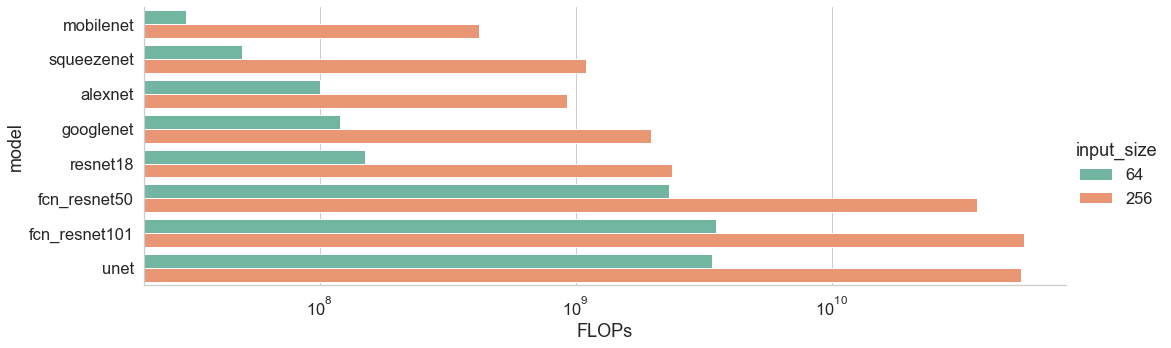

In [12]:
plot_df = FLOP_df.copy()
plot_df[['FLOPs','n_parameters']] = plot_df[['FLOPs','n_parameters']].astype(float)
plot_df['FLOPs'] = 1e9*plot_df['FLOPs'] 
plot_df.loc[plot_df['param_unit']=='k','n_parameters'] = plot_df[plot_df['param_unit']=='k']['n_parameters'].values*1e3
plot_df.loc[plot_df['param_unit']=='M','n_parameters'] = plot_df[plot_df['param_unit']=='M']['n_parameters'].values*1e6

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='model',x='FLOPs', hue='input_size', kind='bar', data=plot_df,palette='Set2',aspect=3)

    g.set(xscale="log") 
    

## Measure energy

In [13]:
def measure_inference_energy(x, model, handler):
    @measure_energy(handler=handler)
    def predict(x, model):
        x_tensor = torch.from_numpy(x).float()
        model.eval()
        y = model(torch.tensor(x_tensor))
        return y
        
    predict(x,model)


In [14]:
func_name = 'predict'
joules_csv = '{}{}_joules_all_models.csv'.format(results_dir, func_name)

print('Saving joules results here: {}'.format(joules_csv))
csv_handler = CSVHandler(joules_csv)

model_names = []
for name, model in model_dict.items():
    for input_size in input_size_list:
        model_names.append(name)
        x = np.random.random((1, n_channels, input_size, input_size))
        measure_inference_energy(x, model, csv_handler)
        
csv_handler.save_data()

Saving joules results here: ../results/predict_joules_all_models.csv


In [15]:
joules_df  = pd.read_csv(joules_csv,sep=';')
joules_df['model'] = model_names
joules_df['input_size']= np.tile(input_size_list,len(model_dict))

joules_df.head()

,timestamp,tag,duration,package_0,dram_0,core_0,uncore_0,model,input_size
0,1.612997e+09,predict,0.024525,489317.0,53406.0,312560.0,98327.0,mobilenet,64
1,1.612997e+09,predict,0.058312,1237912.0,170287.0,707701.0,314819.0,mobilenet,256
2,1.612997e+09,predict,0.014569,340087.0,37171.0,194946.0,98937.0,squeezenet,64
3,1.612997e+09,predict,0.070509,1732478.0,190674.0,1183591.0,360656.0,squeezenet,256
4,1.612997e+09,predict,0.020356,441466.0,75318.0,267699.0,93933.0,alexnet,64


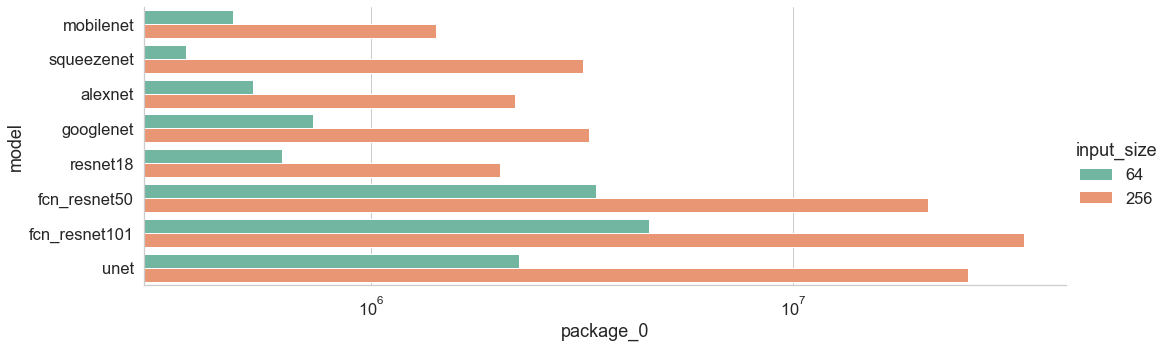

In [32]:
plot_df = joules_df.copy()
sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='model',x='package_0', hue='input_size', kind='bar', data=plot_df, palette='Set2',aspect=3)

    g.set(xscale="log")

### Joint plot of FLOPs and Energy

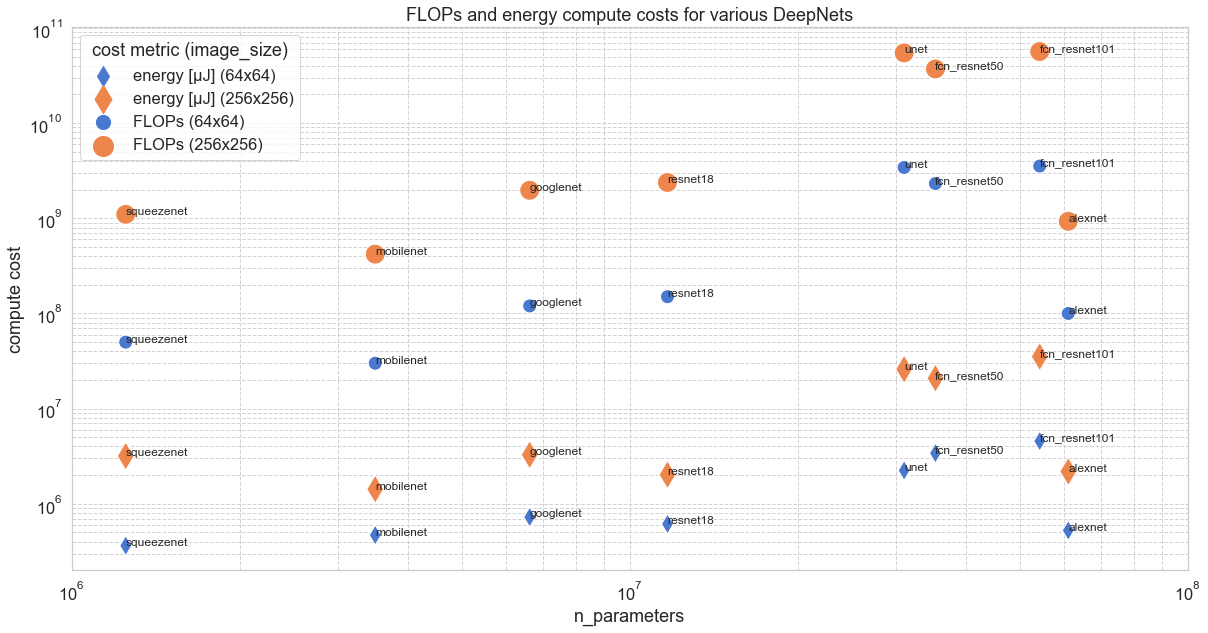

In [34]:
plot_df = pd.merge(FLOP_df, joules_df, on=['model','input_size'])
plot_df['FLOPs'] = 1e9*plot_df['FLOPs'].astype(np.float) 
plot_df['n_parameters'] = 1e6*plot_df['n_parameters'].astype(np.float) 

sns.set(font_scale = 1.5)
palette = sns.color_palette("muted", 2) #sns.color_palette("husl", 2)
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(figsize=(20,10),sharex=True,sharey=True)
    g = sns.scatterplot(x='n_parameters',y='package_0', hue='input_size', size='input_size', sizes=[200,400], style='input_size', markers=['d','d'], data=plot_df, palette=palette,ax=ax1)
    g = sns.scatterplot(x='n_parameters',y='FLOPs', hue='input_size', size='input_size', sizes=[200,400], data=plot_df, palette=palette,ax=ax1)

    g.set(xscale="log",yscale='log')
    g.grid(True,which="both",ls="--",c='lightgray')  
    plt.ylabel('compute cost') #'FLOP count -- energy (μJ)
    plt.title('FLOPs and energy compute costs for various DeepNets')

    g.set(xlim=(1e6, 1e8))
    
    # edit Legend for clarity
    new_labels = ['energy [μJ] (64x64)','energy [μJ] (256x256)','FLOPs (64x64)','FLOPs (256x256)']
    leg = ax1.get_legend()
    leg.set_title('cost metric (image_size)')
    for t, l in zip(leg.texts, new_labels): t.set_text(l)

    # add model names as bubble labels
    def label_point(x, y, val, ax, x_shift=0.1, y_shift=0.1):
        a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
        for i, point in a.iterrows():
            ax.text(point['x']+x_shift, point['y']+y_shift, str(point['val']), fontsize=12)

    label_point(plot_df['n_parameters'], plot_df['package_0'], plot_df['model'], plt.gca())
    label_point(plot_df['n_parameters'], plot_df['FLOPs'], plot_df['model'], plt.gca())

## Unet architecture variations (with no-pretrained models)
- input_size
- init_features 

#### FLOPs

In [7]:
model_name = 'unet'
input_size_list = [256] ## vairable input size does not impact model size in fully-conv-nets 
init_features_list = [8, 16, 32, 64]
n_channels_list = [3]

FLOP_df = pd.DataFrame(columns=['model','input_size','init_features','n_channels','FLOPs','FLOP_unit','n_parameters', 'param_unit']) 
i = 0

for input_size in input_size_list:
    for init_features in init_features_list:
        for n_channels in n_channels_list:        
            model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                in_channels=n_channels, out_channels=1, init_features=init_features, pretrained=False)
                
            macs, params = get_model_complexity_info(model, (n_channels, input_size, input_size), as_strings=True,
                                                    print_per_layer_stat=False, verbose=False)

            FLOP_df.loc[i] = [model_name,input_size,init_features,n_channels] + macs.split(' ') + params.split(' ')
            i = i + 1

FLOP_df.head()

Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


,model,input_size,init_features,n_channels,FLOPs,FLOP_unit,n_parameters,param_unit
0,unet,256,8,3,0.88,GMac,486.55,k
1,unet,256,16,3,3.46,GMac,1.94,M
2,unet,256,32,3,13.74,GMac,7.76,M
3,unet,256,64,3,54.72,GMac,31.04,M


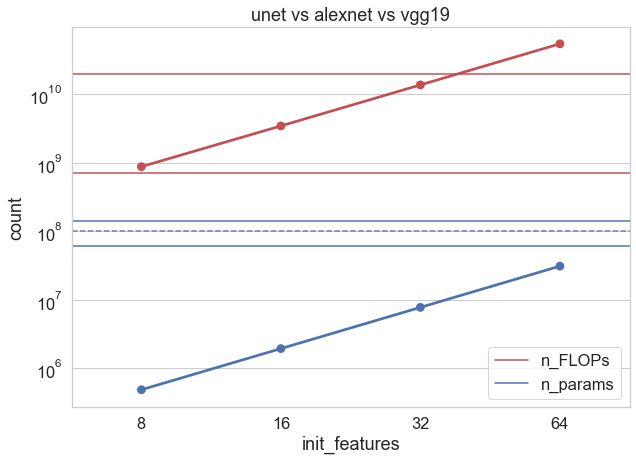

In [8]:
plot_df = FLOP_df[FLOP_df['n_channels']==3].copy()
plot_df[['FLOPs','n_parameters']] = plot_df[['FLOPs','n_parameters']].astype(float)
plot_df['FLOPs'] = 1e9*plot_df['FLOPs'] 
plot_df.loc[plot_df['param_unit']=='k','n_parameters'] = plot_df[plot_df['param_unit']=='k']['n_parameters'].values*1e3
plot_df.loc[plot_df['param_unit']=='M','n_parameters'] = plot_df[plot_df['param_unit']=='M']['n_parameters'].values*1e6
model_name = plot_df['model'].values[0]

sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(figsize=(10,7),sharex=True,sharey=True)
    
    # fixed input size
    # g = sns.pointplot(x='init_features',y='FLOPs', hue='input_size', data=plot_df,ax=ax1,label='FLOPs',palette='Set2')
    g = sns.pointplot(x='init_features',y='FLOPs', color='r', data=plot_df)
    g = sns.pointplot(x='init_features',y='n_parameters', color='b', data=plot_df)

    
    ax1.axhline(0.72e9, color='r', linestyle='-',label='n_FLOPs')
    ax1.axhline(61e6, color='b', linestyle='-',label='n_params')
    ax1.axhline(19.7e9, color='r', linestyle='-')
    ax1.axhline(143e6, color='b', linestyle='-')

    ax1.axhline(1e8, color='m', linestyle='--')

    plt.legend()

    g.set(yscale="log") 
    plt.ylabel('count')
    plt.title('unet vs alexnet vs vgg19'.format(model_name))

#### Energy

In [39]:
func_name = 'predict'
joules_csv = '{}{}_joules_unet.csv'.format(results_dir, func_name)

print('Saving joules results here: {}'.format(joules_csv))
csv_handler = CSVHandler(joules_csv)

input_size_list = [256]
init_features_list = [8,16,32,64]

for input_size in input_size_list:
    for init_features in init_features_list:
        x = np.random.random((1, 3, input_size, input_size))

        model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
            in_channels=3, out_channels=1, init_features=init_features, pretrained=False)

        measure_inference_energy(x, model, csv_handler)
        
csv_handler.save_data()

Saving joules results here: ../results/predict_joules_unet.csv
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
Using cache found in /home/nikhil/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [9]:
func_name = 'predict'
joules_csv = '{}{}_joules_unet.csv'.format(results_dir, func_name)

joules_df = pd.read_csv(joules_csv,sep=';')
joules_df['input_size']= np.repeat(input_size_list,len(init_features_list))
joules_df['init_features'] = np.tile(init_features_list,len(input_size_list))
joules_df.head()

,timestamp,tag,duration,package_0,dram_0,core_0,uncore_0,input_size,init_features
0,1.611601e+09,predict,0.120932,2046992.0,314330.0,1438533.0,233947.0,256,8
1,1.611601e+09,predict,0.312476,4761524.0,800352.0,3170463.0,679076.0,256,16
2,1.611601e+09,predict,0.548822,8394205.0,1347836.0,5627549.0,1252010.0,256,32
3,1.611601e+09,predict,1.521226,23108828.0,3764578.0,15856465.0,3041740.0,256,64


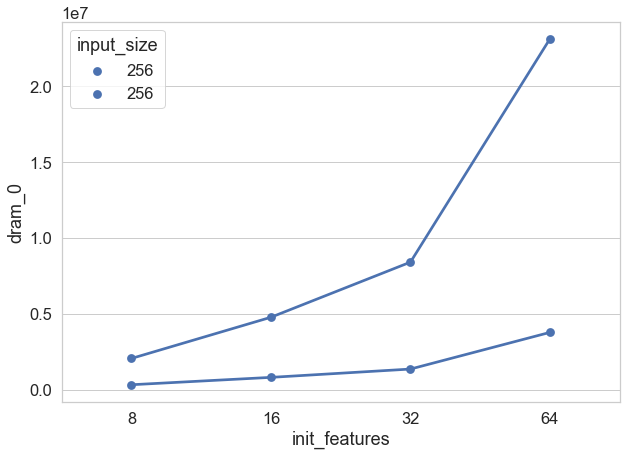

In [10]:
plot_df = joules_df.copy()
sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(figsize=(10,7),sharex=True,sharey=True)
    
    # fixed input size
    g = sns.pointplot(x='init_features',y='package_0', hue='input_size', data=plot_df,ax=ax1,label='package')
    g = sns.pointplot(x='init_features',y='dram_0', hue='input_size', data=plot_df, ax=ax1, label='dram')


### UNet perf

In [32]:
perf_dir = '../../brain-segmentation-pytorch/logs/'
init_features_list = [8,16,32,64]

train_loss_dict = {}
valid_loss_dict = {}
dsc_dict = {}

# with open('{}UNet_{}_train_loss.pkl'.format(perf_dir,init_features),'rb') as f:
#     train_loss = pickle.load(f)
#     train_loss_dict[init_features] = train_loss

# with open('{}UNet_{}_valid_loss.pkl'.format(perf_dir,init_features),'rb') as f:
#     valid_loss = pickle.load(f)
#     valid_loss_dict[init_features] = valid_loss

for init_features in init_features_list:
    with open('{}UNet_{}_valid_dsc.pkl'.format(perf_dir,init_features),'rb') as f:
        valid_dsc = pickle.load(f)
    print('{} max perf: {}, mid_perf: {}, end perf: {}'.format(init_features, np.max(valid_dsc),valid_dsc[4],valid_dsc[-1]))
    dsc_dict[init_features] = valid_dsc

8 max perf: 0.8083019315612802, mid_perf: 0.794256040906268, end perf: 0.8064811264759358
16 max perf: 0.8128855295696106, mid_perf: 0.8078799859255069, end perf: 0.8123909382918223
32 max perf: 0.8150471366061499, mid_perf: 0.8150471366061499, end perf: 0.8122447262879344
64 max perf: 0.9061927619787037, mid_perf: 0.813473762108282, end perf: 0.8147162557636521


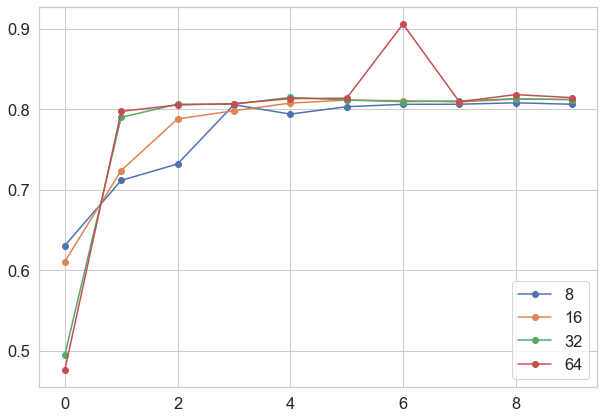

In [33]:
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(1,figsize=(10,7),sharex=True,sharey=True)
    # for init_features, train_loss in train_loss_dict.items():
    #     axes[0].plot(np.array(train_loss),label='train, {}'.format(init_features))
    # plt.legend()

    # for init_features, valid_loss in valid_loss_dict.items():
    #     axes[0].plot(np.array(valid_loss),label='valid, {}'.format(init_features))
    # plt.legend()

    # axes[0].title('Loss')

    for init_features, valid_dsc in dsc_dict.items():
        axes.plot(np.array(valid_dsc),'-o',label=init_features)
    plt.legend()
    # axes[1].title('DSC')

In [20]:
unet_perf = pd.DataFrame()
unet_perf['init_features'] = [8,16,32,64]
unet_perf['Dice_score'] = [0.809,0.812,0.813,0.815]
unet_perf['input_size'] = 256
unet_perf

,init_features,Dice_score,input_size
0,8,0.809,256
1,16,0.812,256
2,32,0.813,256
3,64,0.815,256


In [41]:
5.472000e+10 / 8.800000e+08	

62.18181818181818

In [21]:
plot_df = pd.merge(FLOP_df, joules_df, on = ['input_size','init_features']) 
plot_df = pd.merge(plot_df, unet_perf, on = ['input_size','init_features']) 
plot_df[['FLOPs','n_parameters']] = plot_df[['FLOPs','n_parameters']].astype(float)
plot_df['FLOPs'] = 1e9*plot_df['FLOPs'] 
plot_df.loc[plot_df['param_unit']=='k','n_parameters'] = plot_df[plot_df['param_unit']=='k']['n_parameters'].values*1e3
plot_df.loc[plot_df['param_unit']=='M','n_parameters'] = plot_df[plot_df['param_unit']=='M']['n_parameters'].values*1e6
plot_df.head()

,model,input_size,init_features,n_channels,FLOPs,FLOP_unit,n_parameters,param_unit,timestamp,tag,duration,package_0,dram_0,core_0,uncore_0,Dice_score
0,unet,256,8,3,8.800000e+08,GMac,486550.0,k,1.611601e+09,predict,0.120932,2046992.0,314330.0,1438533.0,233947.0,0.809
1,unet,256,16,3,3.460000e+09,GMac,1940000.0,M,1.611601e+09,predict,0.312476,4761524.0,800352.0,3170463.0,679076.0,0.812
2,unet,256,32,3,1.374000e+10,GMac,7760000.0,M,1.611601e+09,predict,0.548822,8394205.0,1347836.0,5627549.0,1252010.0,0.813
3,unet,256,64,3,5.472000e+10,GMac,31040000.0,M,1.611601e+09,predict,1.521226,23108828.0,3764578.0,15856465.0,3041740.0,0.815


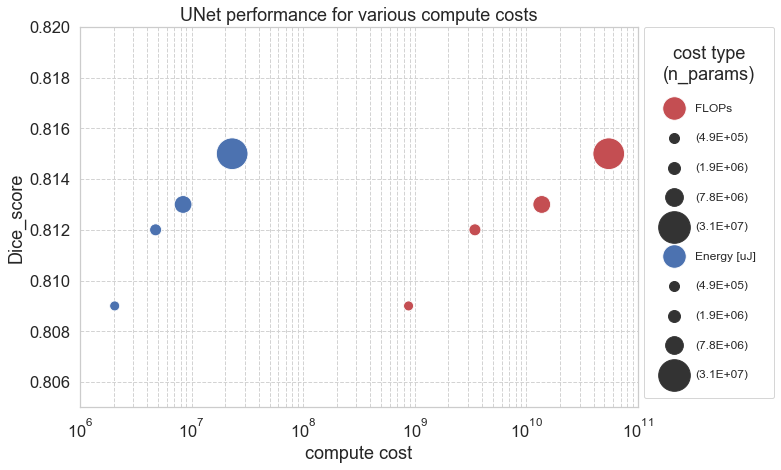

In [23]:
sns.set(font_scale = 1.5)
minsize, maxsize = 100,1000
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(figsize=(10,7),sharex=True,sharey=True)
    
    # fixed input size
    g = sns.scatterplot(x='FLOPs',y='Dice_score', color='r', size='n_parameters', sizes=(minsize, maxsize), data=plot_df,ax=ax1,label='FLOPs')
    g = sns.scatterplot(x='package_0',y='Dice_score', color='b', size='n_parameters', sizes=(minsize, maxsize), data=plot_df,ax=ax1,label='Energy [uJ]')

    g.set(xscale='log') 
    g.grid(True,which="both",ls="--",c='lightgray')  
    plt.xlabel('compute cost') 
    plt.title('UNet performance for various compute costs')

    g.set(xlim=(1e6, 1e11),ylim=(0.805,0.82))

    handles, labels = ax1.get_legend_handles_labels()

    # handles = handles[:6]
    # labels = labels[:6]

    new_labels = []
    for l in labels:
        if l in ['FLOPs','Energy [uJ]']:
            new_labels.append(l)
        else:
            l = '({:.1E})'.format(float(l))
            new_labels.append(l)

    plt.legend(handles, new_labels, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., borderpad=1.5, labelspacing=1.6, 
    title="  cost type\n(n_params)",fancybox=True, fontsize=12)

    